# Nature CNN Recreation using PyTorch

In [1]:
%cd ..

/home/marcusp/Documents/traffic-sign-classification


## Data

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from dataio.gtsrb_dataset import GTSRBDataset
from torchvision import transforms
import numpy as np

# Define chosen classes
chosen_classes = {1, 2, 10, 13, 38}
labels = GTSRBDataset().labels_data  # Assuming labels_data is accessible

# Filter indices for chosen classes
filtered_indices = [i for i, (_, label) in enumerate(labels) if label in chosen_classes]

# Group indices by class
class_indices = {class_label: [] for class_label in chosen_classes}
for index in filtered_indices:
    _, label = labels[index]
    if label in chosen_classes:
        class_indices[label].append(index)

# Clip each class to 2500 images and combine
clipped_indices = []
for label in chosen_classes:
    indices = class_indices[label]
    if len(indices) > 2500:
        indices = np.random.choice(indices, size=2500, replace=False)
    clipped_indices.extend(indices)

# Shuffle the clipped indices
clipped_indices = np.array(clipped_indices)
np.random.shuffle(clipped_indices)

# Split into training and testing sets
dataset_length = len(clipped_indices)
train_split = clipped_indices[:int(0.85 * dataset_length)]
test_split = clipped_indices[int(0.15 * dataset_length):]

In [3]:
# Set up the data transformations
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Set up the datasets with for_torch=True
train_dataset = GTSRBDataset(
    indices=train_split,
    split="train",
    transforms=train_transforms,
    for_torch=True  # Set the for_torch flag to True
)

test_dataset = GTSRBDataset(
    indices=test_split,
    split="test",
    transforms=val_transforms,
    for_torch=True  # Set the for_torch flag to True
)

# Set up the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Architecture

In [4]:
import torch.nn as nn
import torch.nn.init as init

# Define the model architecture
layers = [
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=256, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=84),
    nn.ReLU(),
    nn.Linear(in_features=84, out_features=5)
]

# Create the model
model = nn.Sequential(*layers)

# Initialize weights with He initialization
for layer in model:
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')


In [5]:
import torch.optim as optim

param_dict = dict(model.named_parameters())
optimiser = optim.SGD(param_dict.values(), lr=0.01, momentum=0.9, weight_decay=0.0005)
loss_fn = nn.MSELoss()

## Training

In [6]:
import torch
from tqdm import tqdm
from typing import List, Tuple

def train_pytorch(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader = None,
    loss_fn: torch.nn.Module = None,
    optimiser: torch.optim.Optimizer = None,
    num_epochs: int = 10,
) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Train the model and log metrics.
    Returns:
        Tuple of training losses, validation losses, training accuracies, validation accuracies.
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Create a mapping from old class indices to new class indices
    class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(chosen_classes)}

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}.")

        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        n_train_samples = 0

        # Use tqdm for the training loader
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for b_data, b_labels in train_loop:
            n_train_samples += b_data.size(0)
            optimiser.zero_grad()
            outputs = model(b_data)
            # Filter the labels to only include the chosen classes
            mask = torch.isin(b_labels, torch.tensor(list(chosen_classes)))
            if not mask.any():
                continue
            filtered_b_labels = b_labels[mask]
            # Convert labels to new class indices
            filtered_b_labels = torch.tensor([class_mapping[label.item()] for label in filtered_b_labels])
            # Convert labels to one-hot encoding with the correct number of classes
            b_labels_one_hot = torch.zeros(filtered_b_labels.size(0), len(chosen_classes)).scatter_(1, filtered_b_labels.unsqueeze(1), 1)
            # Filter the outputs to only include the chosen classes
            outputs = outputs[mask]
            loss = loss_fn(outputs, b_labels_one_hot)
            loss.backward()
            optimiser.step()

            epoch_train_loss += loss.item() * b_data.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_train_acc += (preds == filtered_b_labels).sum().item()

            # Update progress bar with current loss and accuracy
            batch_acc = (preds == filtered_b_labels).sum().item() / b_data.size(0)
            train_loop.set_postfix(loss=loss.item(), acc=batch_acc)

        # Average metrics
        epoch_train_loss /= n_train_samples
        epoch_train_acc /= n_train_samples
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")

        # Validation phase
        if val_loader is not None:
            model.eval()
            epoch_val_loss = 0.0
            epoch_val_acc = 0.0
            n_val_samples = 0

            # Use tqdm for the validation loader
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
            with torch.no_grad():
                for b_data, b_labels in val_loop:
                    n_val_samples += b_data.size(0)
                    outputs = model(b_data)
                    # Filter the labels to only include the chosen classes
                    mask = torch.isin(b_labels, torch.tensor(list(chosen_classes)))
                    if not mask.any():
                        continue
                    filtered_b_labels = b_labels[mask]
                    # Convert labels to new class indices
                    filtered_b_labels = torch.tensor([class_mapping[label.item()] for label in filtered_b_labels])
                    # Convert labels to one-hot encoding with the correct number of classes
                    b_labels_one_hot = torch.zeros(filtered_b_labels.size(0), len(chosen_classes)).scatter_(1, filtered_b_labels.unsqueeze(1), 1)
                    # Filter the outputs to only include the chosen classes
                    outputs = outputs[mask]
                    loss = loss_fn(outputs, b_labels_one_hot)
                    epoch_val_loss += loss.item() * b_data.size(0)
                    _, preds = torch.max(outputs, 1)
                    epoch_val_acc += (preds == filtered_b_labels).sum().item()

                    # Update progress bar with current loss and accuracy
                    batch_acc = (preds == filtered_b_labels).sum().item() / b_data.size(0)
                    val_loop.set_postfix(loss=loss.item(), acc=batch_acc)

            epoch_val_loss /= n_val_samples
            epoch_val_acc /= n_val_samples
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)
            print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

In [7]:
# Train the model.
train_losses, _, train_accs, _ = train_pytorch(
    model,
    train_loader,
    val_loader=None,
    loss_fn=loss_fn,
    optimiser=optimiser,
    num_epochs=30
)


Starting epoch 1/30.


Epoch 1/30, Train Loss: 0.1052, Train Acc: 0.7242
Starting epoch 2/30.


Epoch 2/30, Train Loss: 0.0462, Train Acc: 0.9317
Starting epoch 3/30.


Epoch 3/30, Train Loss: 0.0327, Train Acc: 0.9565
Starting epoch 4/30.


Epoch 4/30, Train Loss: 0.0256, Train Acc: 0.9672
Starting epoch 5/30.


Epoch 5/30, Train Loss: 0.0213, Train Acc: 0.9745
Starting epoch 6/30.


Epoch 6/30, Train Loss: 0.0185, Train Acc: 0.9795
Starting epoch 7/30.


Epoch 7/30, Train Loss: 0.0165, Train Acc: 0.9802
Starting epoch 8/30.


Epoch 8/30, Train Loss: 0.0149, Train Acc: 0.9827
Starting epoch 9/30.


Epoch 9/30, Train Loss: 0.0136, Train Acc: 0.9852
Starting epoch 10/30.


Epoch 10/30, Train Loss: 0.0125, Train Acc: 0.9863
Starting epoch 11/30.


Epoch 11/30, Train Loss: 0.0117, Train Acc: 0.9881
Starting epoch 12/30.


Epoch 12/30, Train Loss: 0.0108, Train Acc: 0.9889
Starting epoch 13/30.


Epoch 13/30, Train Loss: 0.0102, Train Acc: 0.9892
Starting epoch 14/30.


Epoch 14/30, Train Loss: 0.0095, Train Acc: 0.9902
Starting epoch 15/30.


Epoch 15/30, Train Loss: 0.0091, Train Acc: 0.9914
Starting epoch 16/30.


Epoch 16/30, Train Loss: 0.0086, Train Acc: 0.9916
Starting epoch 17/30.


Epoch 17/30, Train Loss: 0.0082, Train Acc: 0.9922
Starting epoch 18/30.


Epoch 18/30, Train Loss: 0.0078, Train Acc: 0.9924
Starting epoch 19/30.


Epoch 19/30, Train Loss: 0.0074, Train Acc: 0.9932
Starting epoch 20/30.


Epoch 20/30, Train Loss: 0.0072, Train Acc: 0.9936
Starting epoch 21/30.


Epoch 21/30, Train Loss: 0.0068, Train Acc: 0.9929
Starting epoch 22/30.


Epoch 22/30, Train Loss: 0.0066, Train Acc: 0.9939
Starting epoch 23/30.


Epoch 23/30, Train Loss: 0.0064, Train Acc: 0.9942
Starting epoch 24/30.


Epoch 24/30, Train Loss: 0.0062, Train Acc: 0.9946
Starting epoch 25/30.


Epoch 25/30, Train Loss: 0.0060, Train Acc: 0.9945
Starting epoch 26/30.


Epoch 26/30, Train Loss: 0.0059, Train Acc: 0.9951
Starting epoch 27/30.


Epoch 27/30, Train Loss: 0.0057, Train Acc: 0.9949
Starting epoch 28/30.


Epoch 28/30, Train Loss: 0.0056, Train Acc: 0.9949
Starting epoch 29/30.


Epoch 29/30, Train Loss: 0.0053, Train Acc: 0.9955
Starting epoch 30/30.


Epoch 30/30, Train Loss: 0.0052, Train Acc: 0.9954


## Evaluation

In [8]:
def evaluate(
    model: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
) -> Tuple[float, float]:
    """
    Evaluate the model on the test dataset.
    Returns:
        Tuple of test loss and test accuracy.
    """
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    n_test_samples = 0

    # Create a mapping from old class indices to new class indices
    class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(chosen_classes)}

    with torch.no_grad():
        for b_data, b_labels in test_loader:
            n_test_samples += b_data.size(0)
            outputs = model(b_data)
            # Filter the labels to only include the chosen classes
            mask = torch.isin(b_labels, torch.tensor(list(chosen_classes)))
            if not mask.any():
                continue
            filtered_b_labels = b_labels[mask]
            # Convert labels to new class indices
            filtered_b_labels = torch.tensor([class_mapping[label.item()] for label in filtered_b_labels])
            # Convert labels to one-hot encoding with the correct number of classes
            b_labels_one_hot = torch.zeros(filtered_b_labels.size(0), len(chosen_classes)).scatter_(1, filtered_b_labels.unsqueeze(1), 1)
            # Filter the outputs to only include the chosen classes
            outputs = outputs[mask]
            loss = loss_fn(outputs, b_labels_one_hot)
            test_loss += loss.item() * b_data.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += (preds == filtered_b_labels).sum().item()

    test_loss /= n_test_samples
    test_acc /= n_test_samples

    return test_loss, test_acc


In [9]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.0051, Test Acc: 0.9945


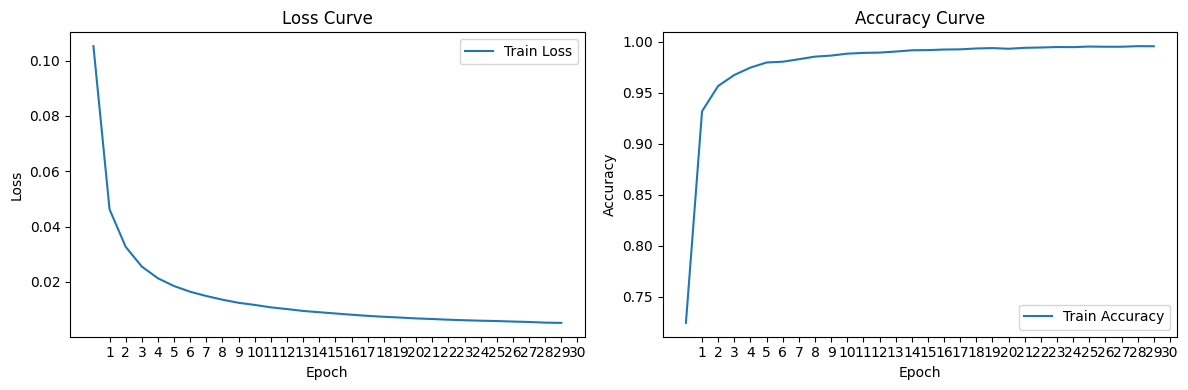

In [10]:
import viz

# Plot the loss and accuracy.
viz.plot_curves(train_losses, train_accs)

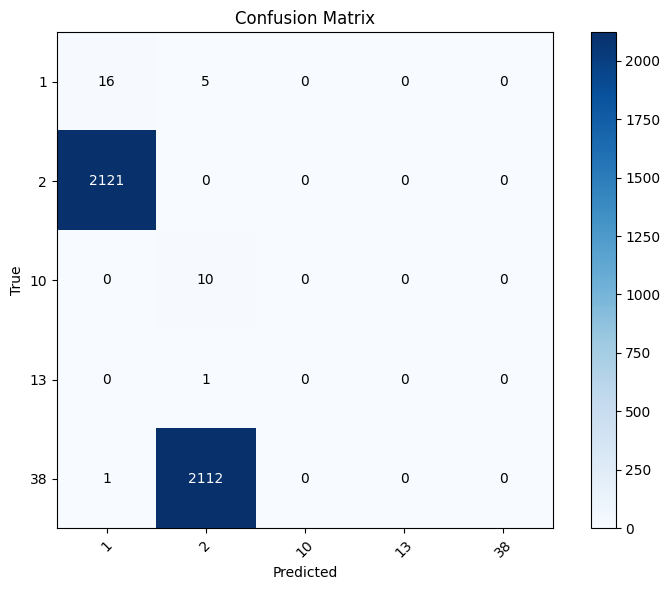

In [11]:
import torch
import numpy as np

all_true_labels = []
all_predictions = []
for batch_data, batch_labels in test_loader:
    with torch.no_grad():
        outputs = model(batch_data)
        predictions = torch.argmax(outputs, dim=1)
    all_true_labels.extend(batch_labels.numpy())
    all_predictions.extend(predictions.numpy())

# Filter the true labels and predictions to include only the classes of interest.
filtered_true_labels = []
filtered_predictions = []
for true, pred in zip(all_true_labels, all_predictions):
    if true in chosen_classes and pred in chosen_classes:
        filtered_true_labels.append(true)
        filtered_predictions.append(pred)

# Plot the confusion matrix using the filtered data.
viz.plot_confusion_matrix(
    np.array(filtered_true_labels),
    np.array(filtered_predictions),
    chosen_classes
)

In [12]:
import torch
import numpy as np

def compute_saliency_map(model, input_sample):
    """
    Compute the saliency map for a given input sample.

    Args:
        model (torch.nn.Module): The model to compute saliency maps for.
        input_sample (torch.Tensor): The input sample.

    Returns:
        torch.Tensor: The saliency map.
    """
    model.eval()
    input_sample = input_sample.unsqueeze(0)  # Add batch dimension
    input_sample.requires_grad_(True)
    output = model(input_sample)
    # Assuming a classification task, take the class with the highest score
    output.max().backward()
    saliency_map = input_sample.grad.data.abs().squeeze()
    return saliency_map

def plot_saliency_map(saliency_map):
    """
    Plot the saliency map.

    Args:
        saliency_map (torch.Tensor): The saliency map to plot.
    """
    import matplotlib.pyplot as plt
    # Normalize the saliency map to the range [0, 1]
    saliency_map = saliency_map / saliency_map.max()
    plt.figure(figsize=(8, 6))
    plt.imshow(saliency_map, cmap="hot")
    plt.colorbar(label="Saliency Value")
    plt.title("Saliency Map")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.tight_layout()
    plt.show()

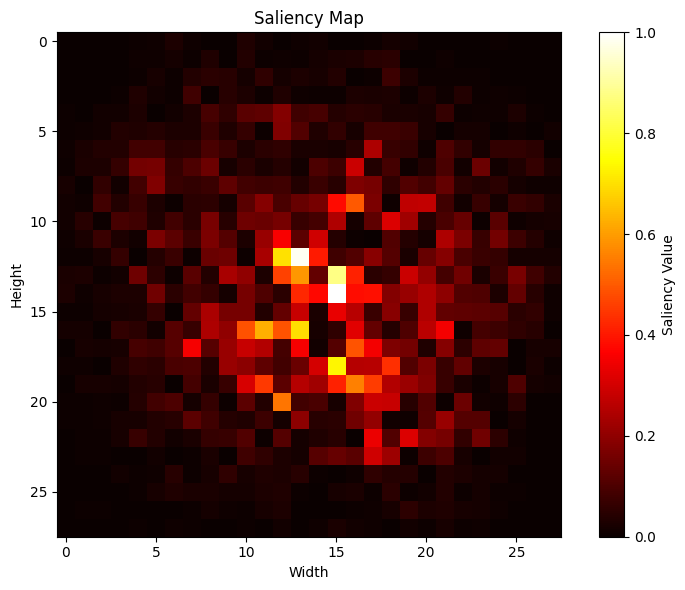

In [13]:
# Compute and plot saliency maps for the first sample.
input_sample = batch_data[0]
saliency_map = compute_saliency_map(model, input_sample)
plot_saliency_map(saliency_map)

In [14]:
def compute_accuracy(
    model: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    """
    Compute the accuracy of the model on the test dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_loader (torch.utils.data.DataLoader): The data loader for the test dataset.

    Returns:
        float: The accuracy of the model on the test dataset.
    """
    model.eval()
    test_acc = 0.0
    n_test_samples = 0

    with torch.no_grad():
        for b_data, b_labels in test_loader:
            n_test_samples += b_data.size(0)
            outputs = model(b_data)
            _, preds = torch.max(outputs, 1)
            test_acc += (preds == b_labels).sum().item()

    test_acc /= n_test_samples

    return test_acc

In [15]:
test_acc = compute_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.0015
